In [6]:
#basic
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use("fivethirtyeight")
%matplotlib inline
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from matplotlib import pyplot
from pylab import rcParams

# For reading stock data 
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

#modeling
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.model_selection import TimeSeriesSplit

np.random.seed(123)

### Univariate time series 
* ARIMA: combines both Autoregression (AR) and Moving Average (MA) models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration (I). AR(p), I(d), and MA(q) models as parameters
* ARIMA(data, order=(1, 1, 1))

* SARIMA: combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level. SARIMA(p, d, q)(P, D, Q)m where  AR(P), I(D), MA(Q) and m parameters at the seasonal level, “m” is the number of time steps in each season (the seasonal period)
* SARIMAX(data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))

* SARIMAX: Exogenous variables are also called covariates and can be thought of as parallel input sequences that have observations at the same time steps as the original series.  
* SARIMAX(data1, exog=data2, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))

## Load Data

In [7]:
df = DataReader('LUV', data_source='yahoo', start='2012-01-01', end=datetime.now())

In [8]:
data = df.filter(['Close'])

In [9]:
dataset = data.values

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [11]:
training_data_len = int(np.ceil( len(dataset) * .9 ))
train_data = scaled_data[0:int(training_data_len), :]

In [12]:
train_data.shape

(2197, 1)

## Data Evaluation

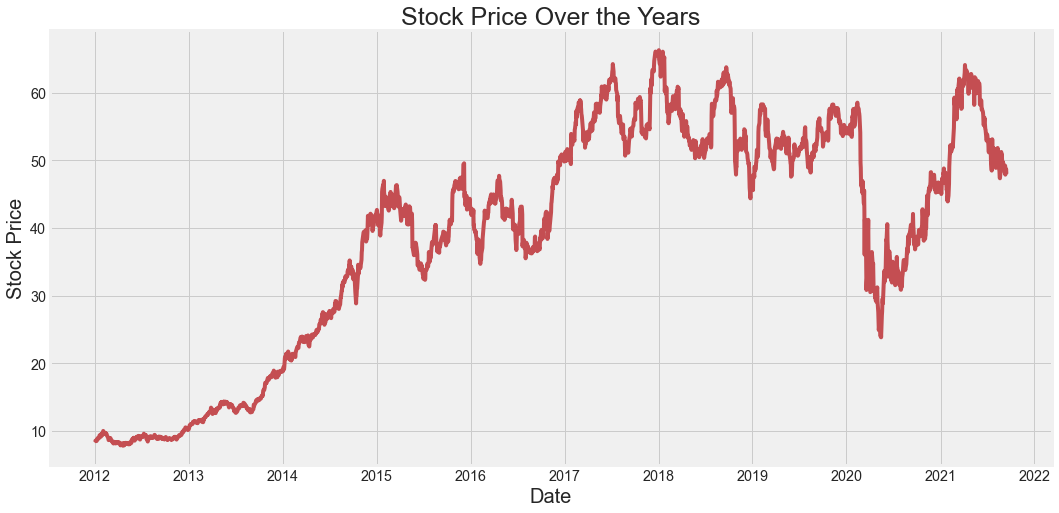

In [13]:
plt.figure(figsize=(16,8))
plt.plot(data['Close'], label='Close.',color='r')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price Over the Years',size=25);

In [14]:
def adfuller_test(stocks):
    result=adfuller(stocks)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

In [15]:
adfuller_test(data)

ADF Test Statistic : -1.8985036502059076
p-value : 0.33276536801245615
#Lags Used : 12
Number of Observations : 2428


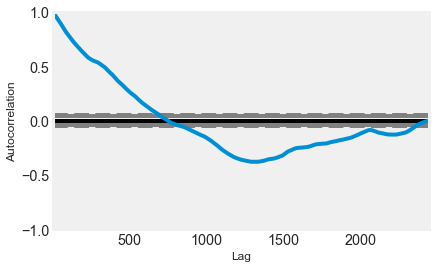

In [16]:
autocorrelation_plot(data['Close'])
plt.show()

In [17]:
data['Close First diff'] = data['Close'] - data['Close'].shift(1)
data['Close Seasonal diff']=data['Close']- data['Close'].shift(12)
data.head()

,Close,Close First diff,Close Seasonal diff
Date,,,
2012-01-03,8.41,NaN,NaN
2012-01-04,8.60,0.190001,NaN
2012-01-05,8.62,0.020000,NaN
2012-01-06,8.52,-0.099999,NaN
2012-01-09,8.59,0.070000,NaN


In [18]:
adfuller_test(data['Close First diff'].dropna())

#rejecting the null hypothesis. So data is stationary.

ADF Test Statistic : -12.432256612958021
p-value : 3.916681899354369e-23
#Lags Used : 11
Number of Observations : 2428


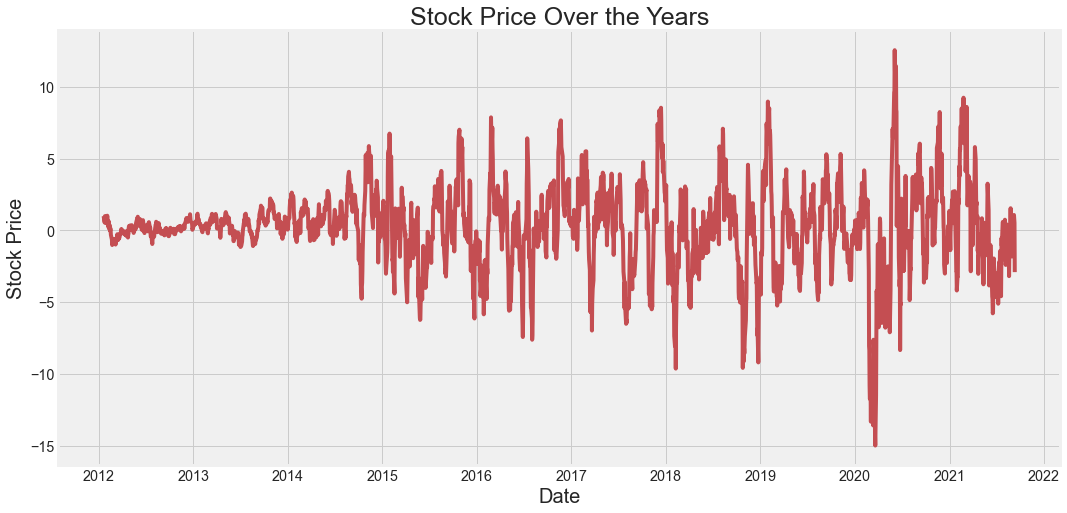

In [14]:
#there is changing in variance so will take the log of the data

plt.figure(figsize=(16,8))
plt.plot(data['Close Seasonal diff'], label='Close Seasonal Diff.',color='r')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price Over the Years',size=25);

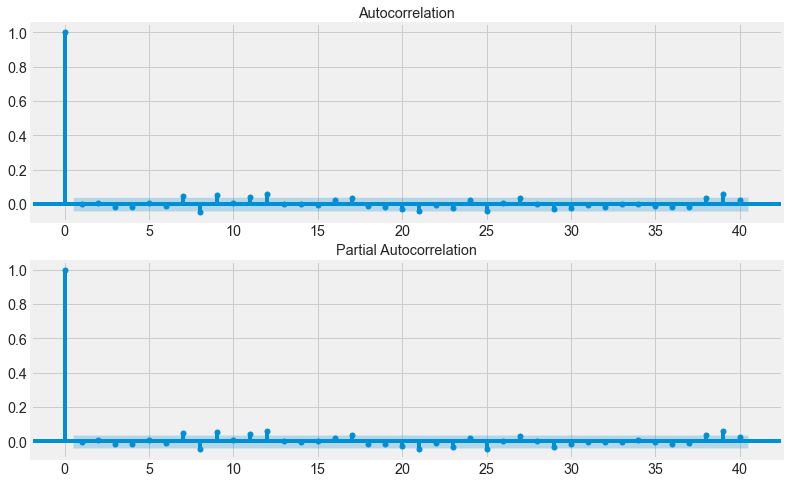

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data['Close First diff'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data['Close First diff'].dropna(),lags=40,ax=ax2)

## Data Preparation

No handles with labels found to put in legend.


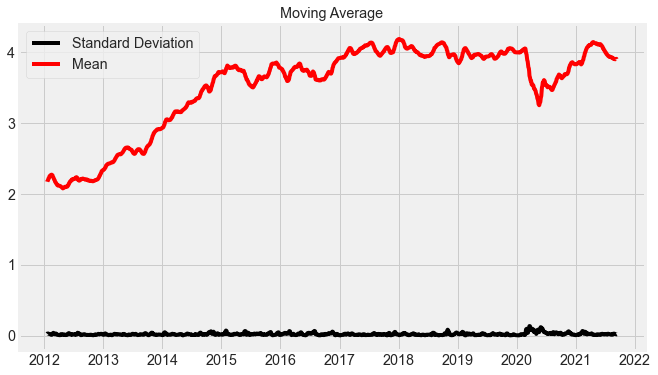

In [16]:
rcParams['figure.figsize'] = 10, 6
df_log = np.log(data['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

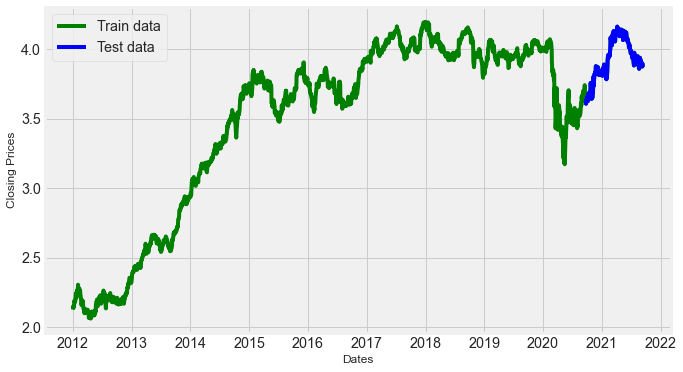

In [17]:
train_data, test_data = df_log[0:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [18]:
len(test_data)

244

### Model1 Base model

In [19]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train_data):
    print(train_ind, val_ind)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

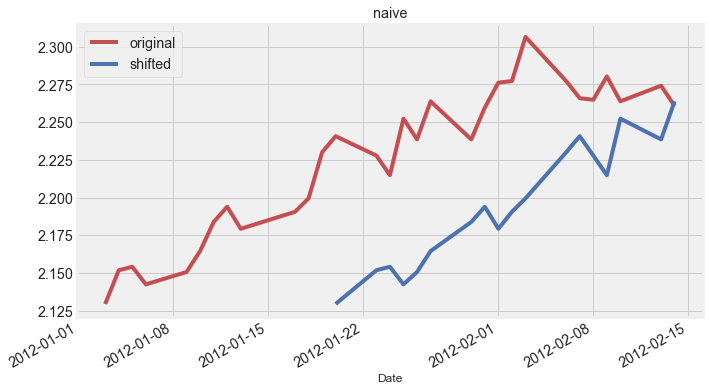

In [20]:
naive = train_data.shift(12)
fig, ax = plt.subplots()

train_data[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [21]:
np.sqrt(mean_squared_error(train_data[12:], naive.dropna()))

0.07142697286806063

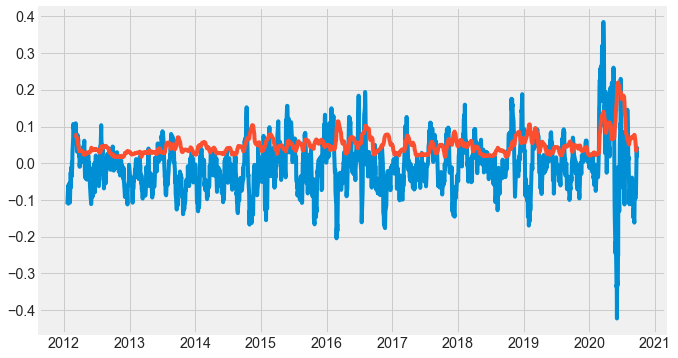

In [22]:
fig, ax = plt.subplots()
residuals = naive[1:] - train_data[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

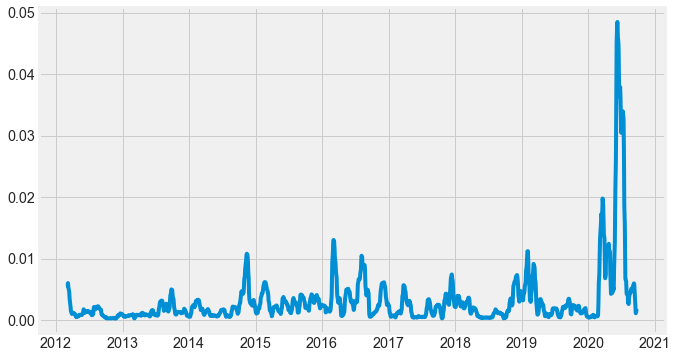

In [23]:
fig, ax = plt.subplots()
ax.plot(residuals.index, residuals.rolling(30).var());

### Model2 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12551.200, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12549.213, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12549.212, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12552.639, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12547.271, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.599 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2197
Model:               SARIMAX(0, 1, 0)   Log Likelihood                6277.320
Date:                Tue, 14 Sep 2021   AIC                         -12552.639
Time:                        17:46:58   BIC                         -12546.945
Sample:                             0   HQIC                        -12550.558
                               - 2197                             

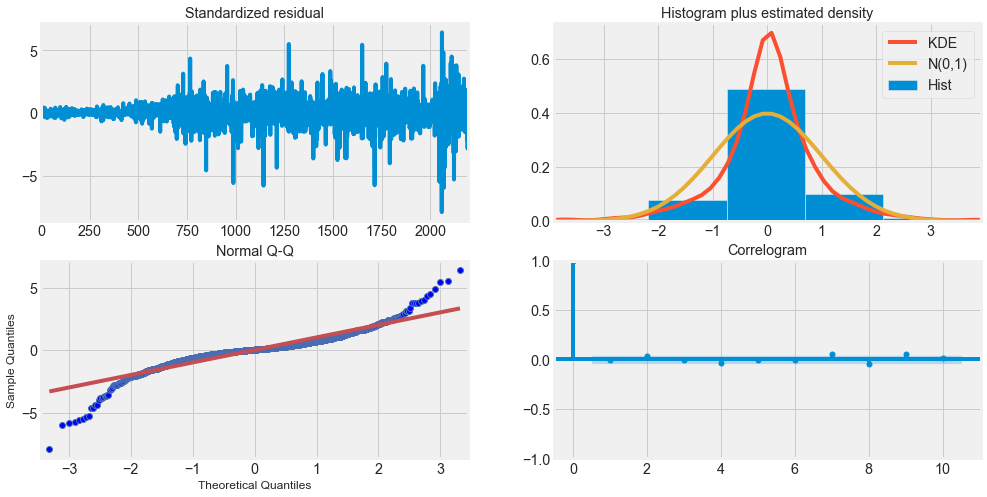

In [21]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=9, max_q=9, # maximum p and q
                      m=1,              # frequency of series
                      d=1,          # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

1. The top left plot shows the residuals over time. We do not want to see any obvious seasonality here and the messier it is, the better we can say we found the trend and seasonality in our data and removed the noise.

2. In the top-right plot, we want to see that the red KDE line follows closely with the N(0,1) line to indicate that the residuals are normally distributed. This line is the standard notation for a normal distribution with a mean of 0 and a standard deviation of 1.

3. In the bottom left qq-plot, you see the ordered distribution of residuals (blue dots) following the linear trend (red line) of the samples taken from a standard normal distribution with N(0, 1).

4. The autocorrelation visual (called a “correlogram”) on the bottom right shows that the time series residuals have a low correlation with the lagged versions of itself (that is, the majority of dots fall into the blue shaded area).

In [22]:
#The best ARIMA model with p,d,q values is 0,1,1 and Seasonal P,D,Q with 0,0,0

model = ARIMA(train_data, order=(0,1,1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2196
Model:                 ARIMA(0, 1, 1)   Log Likelihood                6277.606
Method:                       css-mle   S.D. of innovations              0.014
Date:                Tue, 14 Sep 2021   AIC                         -12549.212
Time:                        17:47:02   BIC                         -12532.129
Sample:                             1   HQIC                        -12542.969
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.751      0.453      -0.000       0.001
ma.L1.D.y     -0.0022      0.021     -0.109      0.913      -0.043       0.038
                                    Roots           

<AxesSubplot:>

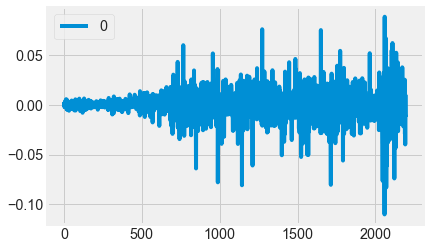

In [23]:
residuals = pd.DataFrame(fitted.resid)
residuals.plot()

In [24]:
print(residuals.describe())

                  0
count  2.196000e+03
mean   7.601686e-09
std    1.387918e-02
min   -1.102530e-01
25%   -4.844913e-03
50%    2.888043e-04
75%    5.592957e-03
max    8.872743e-02


In [25]:
#fc=Array of out of sample forecasts
#se=Array of the standard error of the forecasts.
#conf=2d array of the confidence interval for the forecast

fc, se, conf = fitted.forecast(244, alpha=0.05)  #95% conf

In [28]:
se.mean()

0.14461075526059147

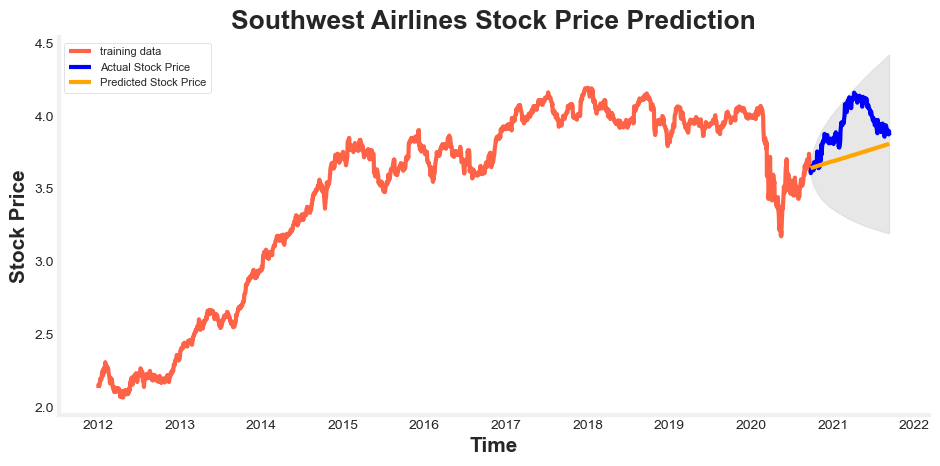

In [29]:
# Make as pandas series

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
with plt.style.context('images/presentation.mplstyle'):
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training data')
    plt.plot(test_data, color = 'blue', label='Actual Stock Price')
    plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.10)
    plt.title('Southwest Airlines Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend(loc='upper left', fontsize=8)
plt.savefig('images/ARIMA.png')
  


In [30]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.05757013788009948
MAE: 0.20544401796545864
RMSE: 0.2399377791847284
MAPE: 0.05122364895492131


In [38]:
fc_inv= np.expm1(fc)

In [39]:
test_inv= np.expm1(test_data)

In [40]:
rmse_inv = sqrt(mean_squared_error(test_inv, fc_inv))
print('RMSE: '+str(rmse))

RMSE: 0.2399377791847284


## Modeling without Log transformation

predicted=37.564736, expected=36.860001
predicted=36.874539, expected=37.099998
predicted=37.112528, expected=38.240002
predicted=38.251108, expected=37.610001
predicted=37.624978, expected=37.500000
predicted=37.513548, expected=37.930000
predicted=37.942315, expected=38.759998
predicted=38.771806, expected=38.490002
predicted=38.504378, expected=37.580002
predicted=37.595453, expected=38.590000
predicted=38.600714, expected=38.990002
predicted=39.002797, expected=39.730000
predicted=39.742330, expected=39.189999
predicted=39.205495, expected=39.130001
predicted=39.144118, expected=39.250000
predicted=39.263658, expected=38.799999
predicted=38.815055, expected=39.680000
predicted=39.691468, expected=39.849998
predicted=39.863730, expected=40.160000
predicted=40.173461, expected=39.840000
predicted=39.855200, expected=41.930000
predicted=41.937918, expected=42.790001
predicted=42.803519, expected=41.099998
predicted=41.120320, expected=39.930000
predicted=39.946553, expected=38.139999


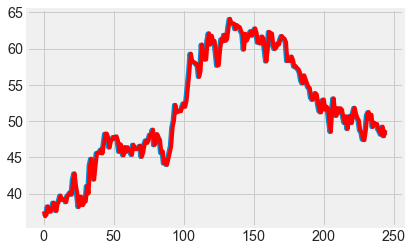

In [29]:
size = int(len(dataset) * 0.9)
train, test = dataset[0:size], dataset[size:len(dataset)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Conclusion: The auto-arima model suggested to use the arima model instead of sarimax model so the data seems to not have seasonality and the result is better after doing the log transformation to stationary the changing variance before applying the model with a root mean squared error 0.2399377791847284.